# 뉴스 요약봇 만들기

### 텍스트 요약

텍스트 요약(Text Summarization)
 
 위 그림과 같이 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것

-추출적 요약(Extractive Summarization)
 
 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식

-추상적 요약(Abstractive Summarization)

 추출적 요약보다 좀 더 흥미로운 접근을 사용합니다. 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것

### 인공 신경망으로 텍스트 요약 훈련시키기

#### seq2seq

두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델

#### LSTM과 컨텍스트 

LSTM이 바닐라 RNN과 다른 점은 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점

인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state와 cell state 두 개의 값 모두 존재해야 함

#### LSTM과 컨텍스트 

인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것

디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식

- 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 디코더의 현재 스텝이 어디냐에 따라 계속 달라진다

- 기본적인 seq2seq 모델에서 컨텍스트 벡터는 디코더의 현재 스텝 위치에 무관하게 한번 계산되면 고정값을 가집니다

## 데이터 준비

In [1]:
# NLTK 패키지에서 불용어 사전을 다운로드
# 데이터 전처리를 위한 나머지 패키지
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
11896,Ireland votes to overturn constitutional ban o...,"In a referendum held on Friday, Ireland voted ..."
60984,Pop-up sushi bar for dogs 'Poochi Sushi' to co...,A pop-up sushi bar for dogs will come up for a...
43809,Cab driver given 10-year jail term for raping ...,A sessions court on Tuesday sentenced a cab dr...
35628,US struck Syria when it had chance for peace: ...,"The US struck Syria ""just at the moment when [..."
78523,IAF to showcase attack helicopter Rudra in R-D...,Indian Air Force will showcase the indigenousl...
88373,Irrfan Khan's 'Hindi Medium' hits the theatres,The Irrfan Khan and Saba Qamar starrer film 'H...
42884,"Travis invests $150 mn in real estate firm, wi...",Uber Co-founder Travis Kalanick has announced ...
38629,Uber driver asks lesbian couple to get out of ...,A video shows an Uber driver asking a lesbian ...
84600,Forget group win over Pak: Kohli warns team be...,Ahead of the Champions Trophy 2017 final clash...
76788,Police complaint over Bigg Boss contestant's s...,A Chennai based lawyer has lodged a complaint ...


#### Headlines 열과 Text 열만 훈련에 사용

In [4]:
data = data[['text','headlines']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,text,headlines
63938,The Trivandrum International Airport in Thiruv...,Kerala airport to halt flights for centuries-o...
78934,President Ram Nath Kovind gave his acceptance ...,"Privileged to walk on same path as Kalam, Pran..."
78705,The benchmark index NSE Nifty closed above the...,"Nifty closes above 10,000 for the first time ever"
75370,Premier League club Tottenham handed Kyle Walk...,"Namesake replaces player in team, wins award o..."
13859,A nine-year-old Noida girl who suffered from c...,"9-year-old denied treatment over Aadhaar, Nadd..."
11171,"Addressing BJP workers on Saturday, Prime Mini...",Kuch neta AK-47 ki tarah dhar dhar jhoot bolte...
92383,Author Taslima Nasreen has said Indian Penal C...,Section 295A of IPC should be abolished: Tasli...
38202,Two Stanford researchers have trained an AI en...,Stanford students train AI bot to make memes
52141,"A 13-year-old girl, who was allegedly gangrape...",Rape victim's medical test delayed over absenc...
25597,Microsoft is updating Skype to include a built...,Skype to get call recording feature 15 years a...


## 데이터 전처리하기

### 데이터 정리

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

중복 샘플 유무 확인

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 샘플에서 불용어 제거

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


#### 전처리 전, 후의 결과 확인

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


기본적으로 모든 알파벳이 소문자로 변환

html 태그가 제거

(or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거

특수문자가 제거되면서 영어만 남음

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False

In [14]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


데이터들을 데이터프레임에 재저장

빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련데이터와 테스트데이터 나누기

#### Text와 Headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


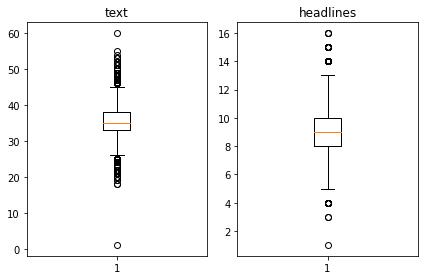

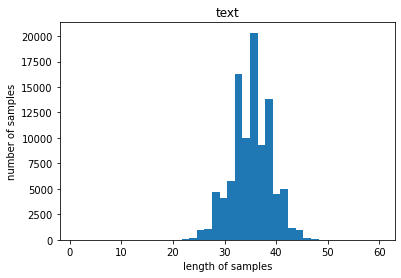

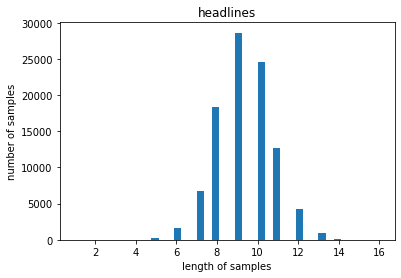

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 지정

In [19]:
text_max_len = 70
headlines_max_len = 15
print('=3')

=3


In [20]:
#훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 70 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98357


#### 시작 토큰과 종료 토큰 추가

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [24]:
#Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[79778 94495 56643 ... 65422 59821 67922]


In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


#### 훈련 데이터 테스트 데이터 8:2 분리

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19671


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78686
훈련 레이블의 개수 : 78686
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


### 정수 인코딩

In [29]:
# Keras의 토크나이저를 사용하여 훈련 데이터로부터 단어 집합을 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69419
등장 빈도가 6번 이하인 희귀 단어의 수: 47256
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22163
단어 집합에서 희귀 단어의 비율: 68.0735821605036
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.472865724380346


In [31]:
# 단어 집합의 크기를 8,000으로 제한
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[210, 33, 7262, 1395, 276, 195, 453, 2520, 106, 1648, 371, 894, 2520, 106, 734, 3790, 4110, 371, 1629, 344, 36, 3445, 879, 1420, 1567, 344, 435, 68, 200, 371, 6039, 836, 371, 276], [137, 2431, 1997, 180, 2591, 571, 1144, 387, 41, 255, 441, 6256, 2531, 643, 4805, 2892, 4173, 255, 1528, 5094, 4335, 137, 6475, 100, 16, 2869, 525, 16], [5, 16, 123, 42, 60, 806, 236, 437, 702, 495, 71, 1110, 403, 941, 24, 2208, 2484, 270, 42, 1, 495, 1321, 1437, 2638, 950, 437, 2302, 149, 227, 1830, 417, 1178, 1288, 290, 1124, 1780]]


텍스트 데이터가 아니라 정수 출력

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30008
등장 빈도가 5번 이하인 희귀 단어의 수: 19619
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10389
단어 집합에서 희귀 단어의 비율: 65.37923220474539
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.666700385005866


등장 빈도가 6회 미만인 단어들은 단어 집합에서 약 77%를 차지

등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.88%
이 단어들은 모두 제거

In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 73, 295, 545, 3, 1297, 250, 303, 97], [1, 567, 359, 1014], [1, 13, 109, 28, 1236, 199, 538, 1147, 97, 315], [1, 596, 1529, 4, 525], [1, 193, 422, 92, 3, 972, 827, 917]]
target
decoder  [[73, 295, 545, 3, 1297, 250, 303, 97, 2], [567, 359, 1014, 2], [13, 109, 28, 1236, 199, 538, 1147, 97, 315, 2], [596, 1529, 4, 525, 2], [193, 422, 92, 3, 972, 827, 917, 2]]


훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장&삭제

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 78676
훈련 레이블의 개수 : 78676
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


### 패딩하기

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춘다

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## 전처리 끝

## 모델 설계하기

#### 함수형 API를 이용해서 인코더를 설계

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [39]:
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 디코더 출력층 설계

In [40]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 70, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 70, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용

어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

## 모델 훈련하기

#### EarlyStopping

'조기 종료'를 뜻함. 특정 조건이 충족되면 훈련을 멈추는 역할

EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈춤

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 295s 906ms/step - loss: 3.1275 - val_loss: 2.9010
Epoch 2/50
308/308 [==============================] - 277s 900ms/step - loss: 2.7555 - val_loss: 2.6329
Epoch 3/50
308/308 [==============================] - 278s 902ms/step - loss: 2.5439 - val_loss: 2.4667
Epoch 4/50
308/308 [==============================] - 277s 900ms/step - loss: 2.3976 - val_loss: 2.3513
Epoch 5/50
308/308 [==============================] - 277s 898ms/step - loss: 2.2855 - val_loss: 2.2663
Epoch 6/50
308/308 [==============================] - 276s 896ms/step - loss: 2.1934 - val_loss: 2.2033
Epoch 7/50
308/308 [==============================] - 277s 900ms/step - loss: 2.1168 - val_loss: 2.1474
Epoch 8/50
308/308 [==============================] - 277s 898ms/step - loss: 2.0516 - val_loss: 2.1055
Epoch 9/50
308/308 [==============================] - 275s 895ms/step - loss: 1.9948 - val_loss: 2.0664
Epoch 10/50
308/308 [==============================] - 276s 895m

val_loss(검증 데이터의 손실)을 관찰하다가, 

검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정

#### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

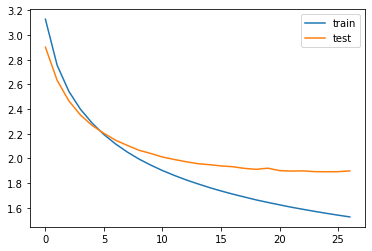

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

In [44]:
#정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야함
#필요한 3개의 사전을 미리 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [45]:
#인코더 모델과 디코더 모델을 분리해서 설계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [46]:
#어텐션 메커니즘을 사용하는 출력층을 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [47]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 모델 테스트하기

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수

Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외

headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bid end vip culture state punjab cabinet decided ban use government vehicles foreign travel ministers two years hosting state also decided provide reservation women government jobs cabinet meeting cm amarinder singh 
실제 요약 : punjab bans on govt cars to end 
예측 요약 :  govt bans ban on india in india


원문 : smart home platform acquired lifestyle technology company owned black singer deal made million plus million commitment towards future manufacturing connects user smart devices smart home network competition amazon alexa apple 
실제 요약 : black singer smart home platform 
예측 요약 :  smart startup makes to mn


원문 : case filed tamil allegedly making remarks hindu goddess function complainant stated devotees goddess hurt remarks police officials said meanwhile claimed quoting book meant goddess 
실제 요약 : case against tamil for remark against hindu 
예측 요약 :  fir against for hindu


원문 : police intelligence officer working killed suspected militants south kashmir pulwama district sunday afte

성능을 개선하기 위해서는

seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법

빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding)

인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)등 여러 방법들이 존재

## 추출적 요약 해보기

### 데이터 다운로드

In [50]:
import requests
from summa.summarizer import summarize

In [51]:
news_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
news_data['text']

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [52]:
for idx, text in enumerate(news_data['text'][:10]):
    print(f'<Original_{idx+1}:> \n{text}')
    print(f'[Summary:] \n{summarize(text, words=20)}\n')

<Original_1:> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[Summary:] 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

<Original_2:> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[Summary:] 
Users get one CRED coin per r

In [53]:
print(news_data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

### summarize 사용

Summa의 summarize()의 인자로 사용되는 값

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수
 (만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.)
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [54]:
print('Summary:')
print(summarize(news_data["text"][i], ratio=0.5))

Summary:
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


In [55]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True
print('Summary:')
print(summarize(news_data['text'][i], ratio=0.5, split=True))

Summary:
['He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".']


In [56]:
#단어의 수로 요약문의 크기를 조절
print('Summary:')
print(summarize(news_data['text'][i], words=50))

Summary:
Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth.
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


## 비교

추출적 요약이 추상적 요약보다 더 비슷하게 요약이 잘 된것 같다.

추상적 요약은 학습이 완벽하게 되지 않아서 그런지 데이터 양, 학습이 더 필요할 것 같다는 생각을 했다.

# 회고

### 이번 프로젝트에서 어려웠던 점

이번 프로젝트는 기다림의 연속이었다. 전처리를 할 때에도 오래걸렸는데 epoch을 돌리는데 너무 많이 걸려서 2시간 동안 아무것도 못하고 앉아있는 일을 3번 정도를 반복하였다.  

### 프로젝트를 진행하면서 알아내거나 모호한 점

summarize를 사용할 떄 숫자 변화에 따라 어떻게 나타나는지를 알 수 있었다.

split = true로 변화되는 텍스트 양을 확인할 수 있는 것을 알 수 있었다.

epoch을 돌릴 때, Early stopping이라는 것을 알게 되어서 너무 행복하다. 훈련을 시킬 떄 최적점에서 멈춰준다는 사실도 너무 좋았고 val_loss값이 다시 올라갈 때 멈출 수 있게 해주는 것이 너무 좋았다. 진작 알았으면 지난 프로젝트에서도 썼을텐데 라는 생각에 조금 아쉬웠다.

### 루브릭 평가 지표에 맞추기 위해 시도한 것

epoch을 멈추지 않고 (earlt stopping을 사용하지 않고) 돌리면 어떤 결과값이 나올지 시도해보고

attractive 방식의 학습이 잘 이뤄진다면 얼마나 자연스러운 문장이 나올지 궁금했다.

text가 긴 문장을 요약할 떄는 어떤 방식이 더 나을까 고민도 해보았지만 아직 미숙한 것 같다.

### 자기다짐

nlp에 대해 조금 더 생각하고 cv에 대해서도 조금 고민을 해봐야할 것 같다.